## Slewtime comparisons with degraded TMA performance

In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
from IPython.display import display

from rubin_scheduler.scheduler.utils import generate_all_sky
from rubin_scheduler.scheduler.model_observatory import tma_movement, KinemModel
from rubin_scheduler.utils import SURVEY_START_MJD, _angular_separation, _approx_ra_dec2_alt_az, Site

The simplest evaluation of impact on slewtime is just "how long does it take to slew from a single spot on the sky, to anywhere else on the sky"? (in simulations, obviously we're slewing between lots of different points).
Let's set up our kinematic model (TMA + DOME + CAMERA), as well as a grid over the sky, in order to make this simple evaluation.

In [2]:
# Set up a grid over the sky
nside = 32
mjd = SURVEY_START_MJD
sky = generate_all_sky(nside=nside)

site = Site('LSST')
alt, az = _approx_ra_dec2_alt_az(
            np.radians(sky['ra']), np.radians(sky['dec']), np.radians(site.latitude), np.radians(site.longitude), mjd, return_pa=False
        )

In [3]:
# Define where the starting point of the slew should be.
starting_alt_rad=np.radians(75)
starting_az_rad=np.radians(75)

dists = _angular_separation(alt, az, starting_alt_rad, starting_az_rad)
dists = np.degrees(dists)

Calculate the simple slewtime from one point to any other point, using the default 70% TMA performance.

Text(0, 0.5, 'Slew time (seconds)')

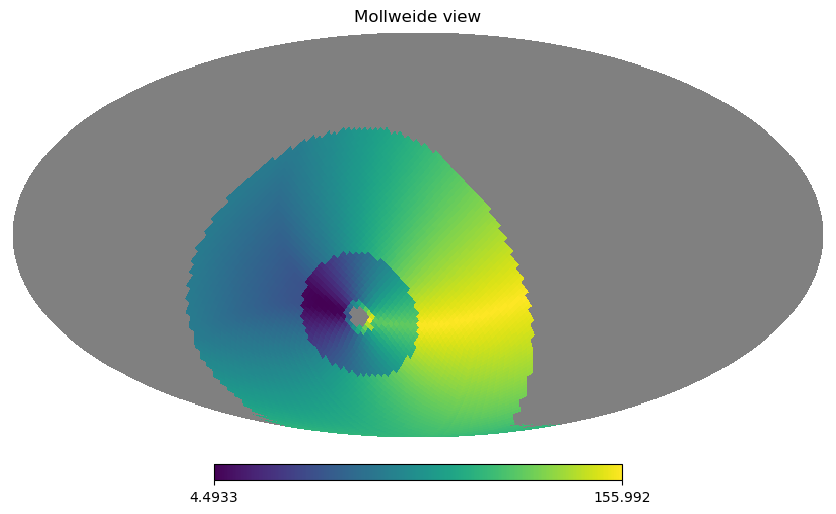

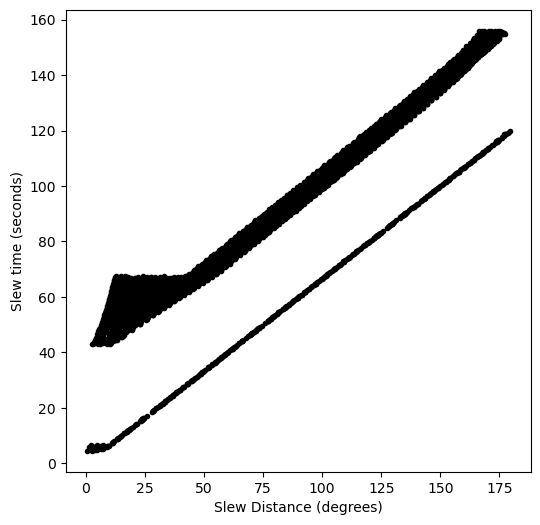

In [4]:
# Set up the kinematic model in the simulation-default mode.

kinematic_model = KinemModel(mjd0=mjd)
tma = tma_movement(70)
kinematic_model.setup_telescope(**tma)
#  Calculate slew times
slewtimes = kinematic_model.slew_times(np.radians(sky['ra']), np.radians(sky['dec']), mjd=SURVEY_START_MJD,
                                      starting_alt_rad=starting_alt_rad, starting_az_rad=starting_az_rad)
nominal = slewtimes

# Plot slew times over the sky
hp.mollview(slewtimes, rot=(120, 0, 0))

# Plot slew times as a function of distance
plt.figure(figsize=(6,6))
plt.plot(dists, slewtimes, 'k.')
plt.xlabel("Slew Distance (degrees)")
plt.ylabel("Slew time (seconds)")

The dome is actually slower than the TMA -- let's see what happens if we speed up the dome by 10% and where this starts to improve slew times. 

Text(0, 0.5, 'Slew time (seconds) - 70% performance')

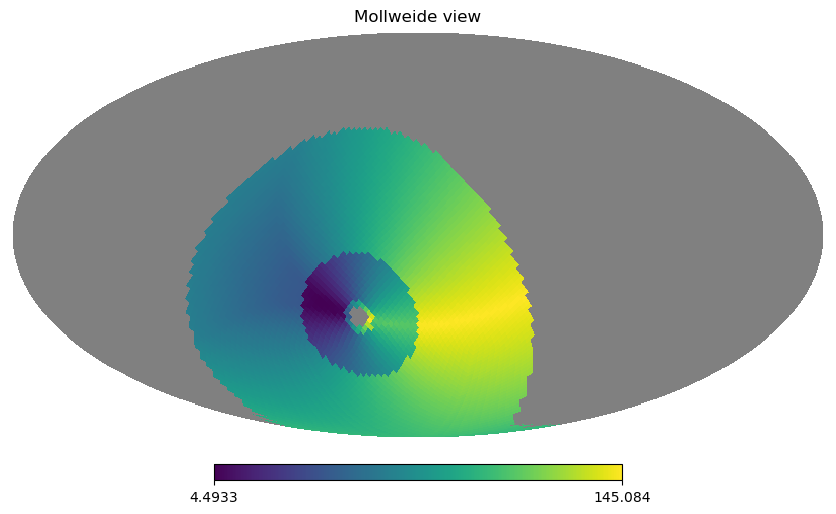

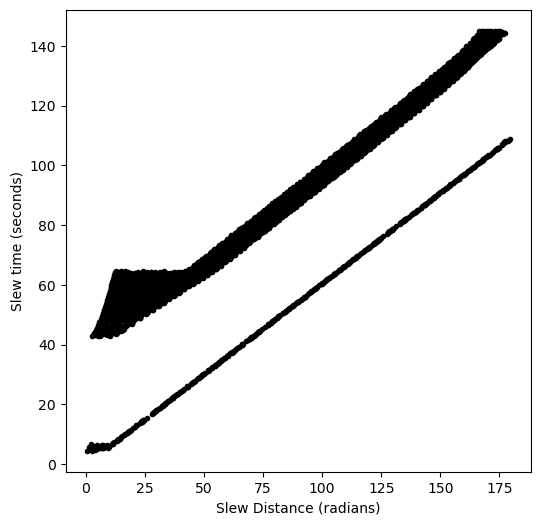

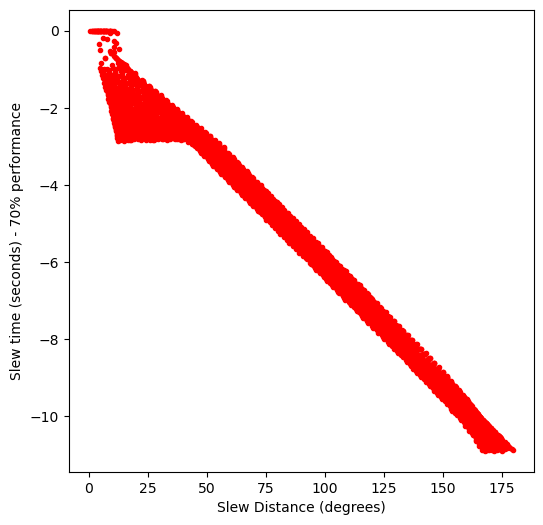

In [5]:
kinematic_model = KinemModel(mjd0=mjd)
tma = tma_movement(70)
kinematic_model.setup_telescope(**tma)
kinematic_model.setup_dome(
        altitude_maxspeed=1.75*1.1,
        altitude_accel=0.875,
        altitude_jerk=None,
        altitude_freerange=0.0,
        azimuth_maxspeed=1.5*1.1,
        azimuth_accel=0.75,
        azimuth_jerk=None,
        azimuth_freerange=4.0,
        settle_time=1.0,
    )
slewtimes = kinematic_model.slew_times(np.radians(sky['ra']), np.radians(sky['dec']), mjd=SURVEY_START_MJD,
                                      starting_alt_rad=starting_alt_rad, starting_az_rad=starting_az_rad)

hp.mollview(slewtimes, rot=(120, 0, 0))

plt.figure(figsize=(6,6))
plt.plot(dists, slewtimes, 'k.')
plt.xlabel("Slew Distance (radians)")
plt.ylabel("Slew time (seconds)")

plt.figure(figsize=(6,6))
#plt.plot(dists, slewtimes, 'k.')
plt.plot(dists, slewtimes - nominal, 'r.')
plt.xlabel("Slew Distance (degrees)")
plt.ylabel("Slew time (seconds) - 70% performance")

Text(0, 0.5, 'Slew time (seconds) - 70% performance')

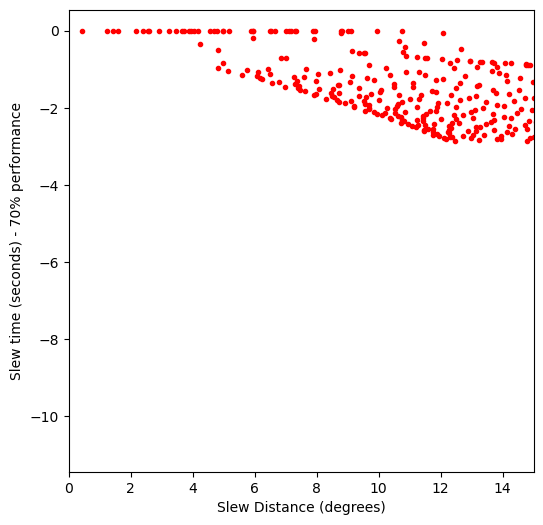

In [6]:
# Zoom in -- 
plt.figure(figsize=(6,6))
#plt.plot(dists, slewtimes, 'k.')
plt.plot(dists, slewtimes - nominal, 'r.')
plt.xlim(0, 15)
plt.xlabel("Slew Distance (degrees)")
plt.ylabel("Slew time (seconds) - 70% performance")

The figure above shows that the slew time improves starting at around 4 degrees, ending at about 13 degrees, with the faster dome. Four degrees also the value for the dome `azimuth_freerange` aka, dome crawl. For slews in altitude, the slews could be a larger distance before requiring the dome to move. The dome looks like the limitation for any slew that requires dome movement. 

Ok, moving on to looking at the impact of changing the TMA performance, which will have an impact for slews where the TMA would have moved faster than the dome.  

Text(0, 0.5, 'Slew time (seconds) / 70% performance')

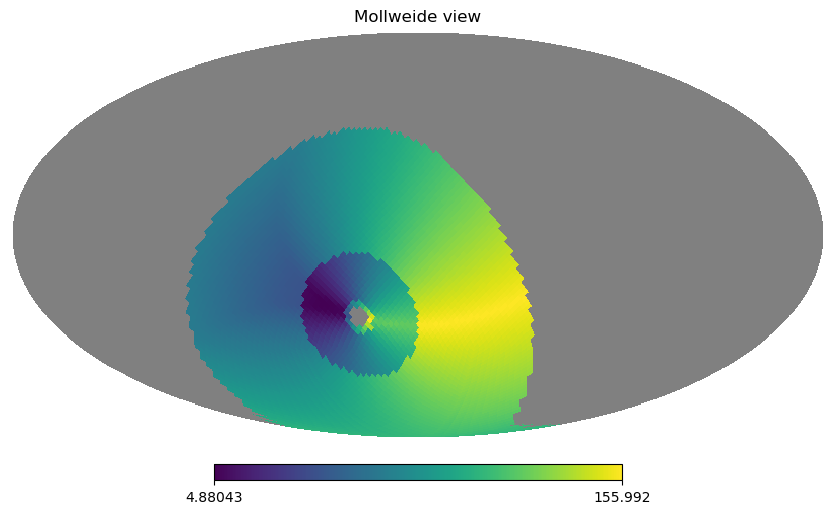

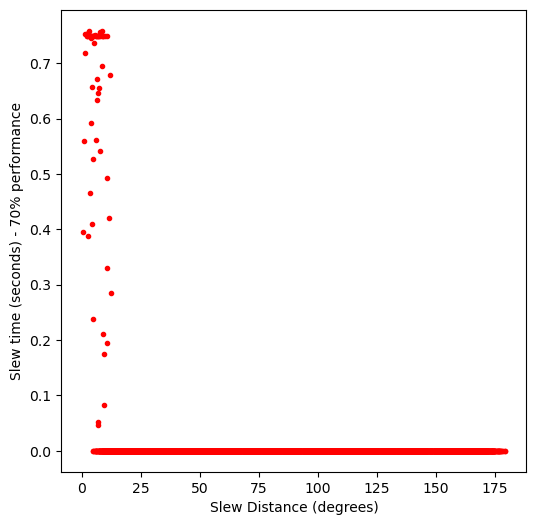

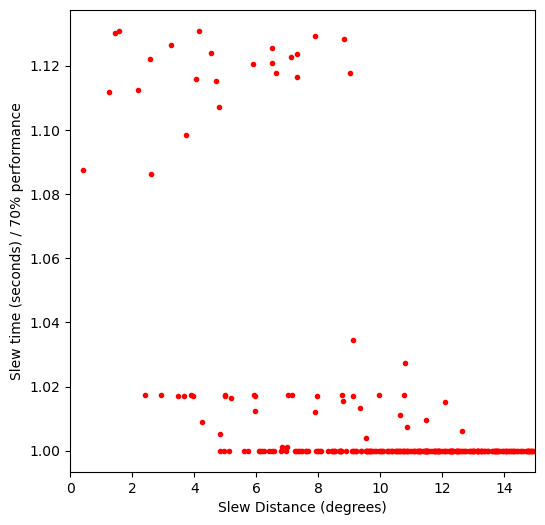

In [7]:
kinematic_model = KinemModel(mjd0=SURVEY_START_MJD)
tma70 = tma_movement(70)
tma40 = tma_movement(40)
tma = {}
for a in ['azimuth', 'altitude']:
    for k in ['accel', 'jerk']:
        key = f"{a}_{k}"
        tma[key] = tma40[key]
    for k in ['maxspeed']:
        key = f"{a}_{k}"
        tma[key] = tma70[key]
tma['settle_time'] = tma40['settle_time']
kinematic_model.setup_telescope(**tma)

slewtimes = kinematic_model.slew_times(np.radians(sky['ra']), np.radians(sky['dec']), mjd=SURVEY_START_MJD,
                                      starting_alt_rad=starting_alt_rad, starting_az_rad=starting_az_rad)
hp.mollview(slewtimes, rot=(120, 0, 0))

plt.figure(figsize=(6,6))
#plt.plot(dists, slewtimes, 'k.')
plt.plot(dists, slewtimes - nominal, 'r.')
plt.xlabel("Slew Distance (degrees)")
plt.ylabel("Slew time (seconds) - 70% performance")

plt.figure(figsize=(6,6))
#plt.plot(dists, slewtimes, 'k.')
plt.plot(dists, slewtimes / nominal, 'r.')
plt.xlim(0, 15)
plt.xlabel("Slew Distance (degrees)")
plt.ylabel("Slew time (seconds) / 70% performance")

If the acceleration and jerk are only 40% performance, while the max velocity remains at 70%, we can still slew fairly quickly over the short distances and beyond ~14 degrees, the dome is still the limiting factor.  The impact is also fairly consistent at about 12%. 

Text(0, 0.5, 'Slew time / 70% (seconds)')

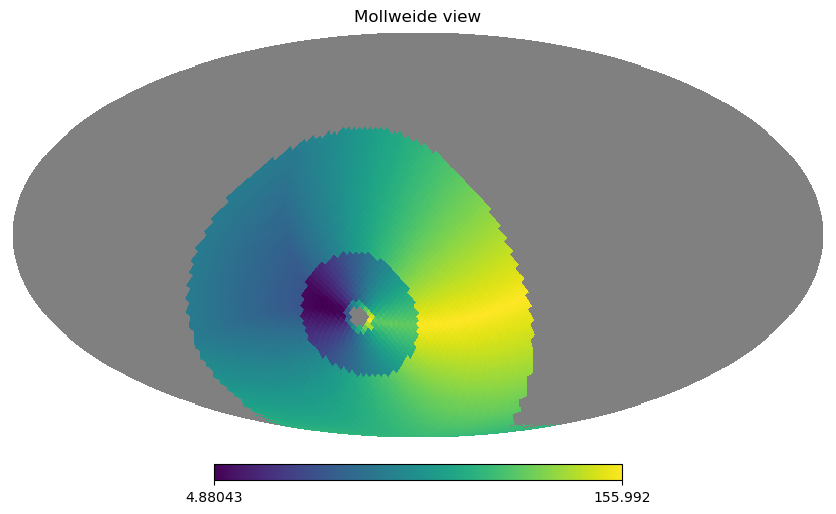

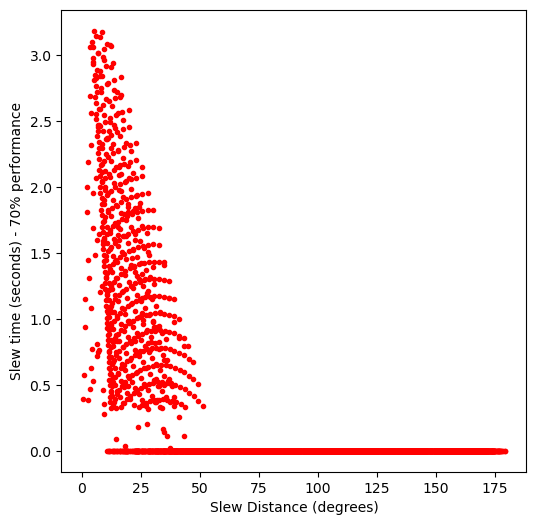

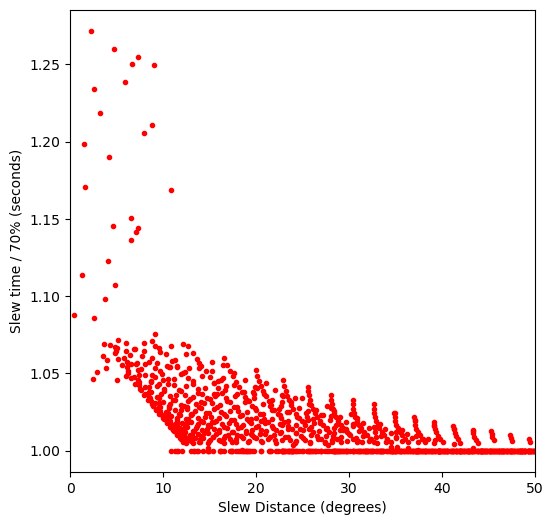

In [8]:
kinematic_model = KinemModel(mjd0=SURVEY_START_MJD)
tma = tma_movement(40)
kinematic_model.setup_telescope(**tma)

slewtimes = kinematic_model.slew_times(np.radians(sky['ra']), np.radians(sky['dec']), mjd=SURVEY_START_MJD,
                                      starting_alt_rad=starting_alt_rad, starting_az_rad=starting_az_rad)
hp.mollview(slewtimes, rot=(120, 0, 0))

plt.figure(figsize=(6,6))
#plt.plot(dists, slewtimes, 'k.')
plt.plot(dists, slewtimes - nominal, 'r.')
plt.xlabel("Slew Distance (degrees)")
plt.ylabel("Slew time (seconds) - 70% performance")

plt.figure(figsize=(6,6))
plt.plot(dists, slewtimes/nominal, 'r.')
#plt.plot(dists, nominal, 'k.', label = 'slew time 70%')
#plt.legend()
plt.xlim(0, 50)
plt.xlabel("Slew Distance (degrees)")
plt.ylabel("Slew time / 70% (seconds)")

With the max velocity of the TMA also reduced to 40% performance, the slew time becomes limited by the TMA to a much greater extent than the dome, even out to some slews over 50 degrees, and the impact is also much larger as much as 3 seconds or as much as 25% increase in slewtime for the shortest slews. 

Finally let's compare with a 100% performance TMA. 

Text(0, 0.5, 'Slew time / 70% (seconds)')

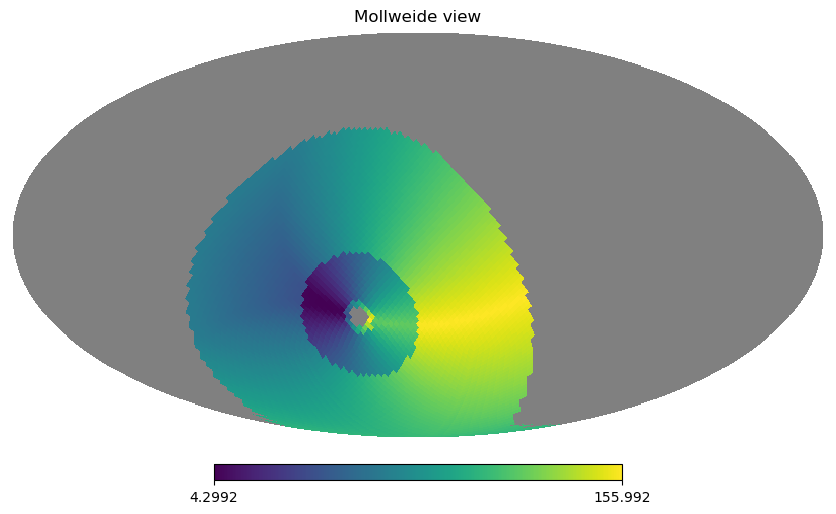

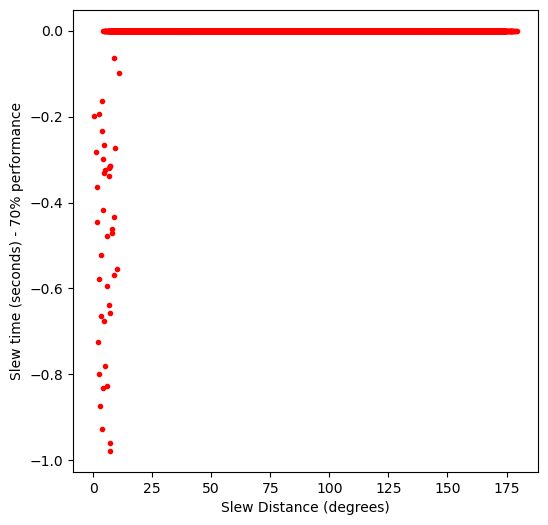

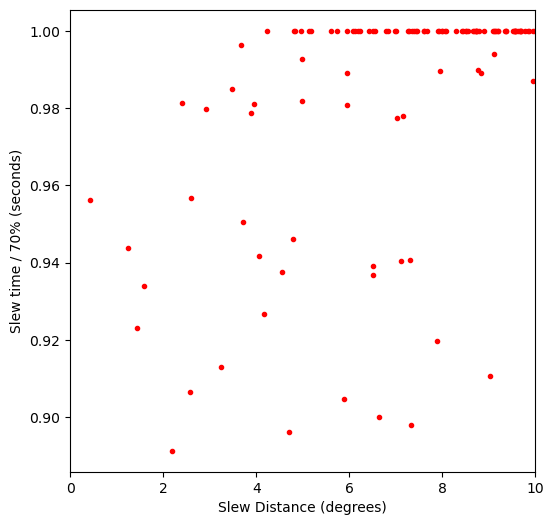

In [9]:
kinematic_model = KinemModel(mjd0=SURVEY_START_MJD)
tma = tma_movement(100)
kinematic_model.setup_telescope(**tma)

slewtimes = kinematic_model.slew_times(np.radians(sky['ra']), np.radians(sky['dec']), mjd=SURVEY_START_MJD,
                                      starting_alt_rad=starting_alt_rad, starting_az_rad=starting_az_rad)
hp.mollview(slewtimes, rot=(120, 0, 0))

plt.figure(figsize=(6,6))
#plt.plot(dists, slewtimes, 'k.')
plt.plot(dists, slewtimes - nominal, 'r.')
plt.xlabel("Slew Distance (degrees)")
plt.ylabel("Slew time (seconds) - 70% performance")

plt.figure(figsize=(6,6))
plt.plot(dists, slewtimes/nominal, 'r.')
#plt.plot(dists, nominal, 'k.', label = 'slew time 70%')
#plt.legend()
plt.xlim(0, 10)
plt.xlabel("Slew Distance (degrees)")
plt.ylabel("Slew time / 70% (seconds)")

A 100% performance TMA could provide over 10% improvement in short slews. 

The actual impact of slewtime on the survey depends on what the typical slew looks like in the survey. Most of the survey slews are short - next field over. 

In [10]:
# What is our actual distribution of slews in these simulations? 

In [11]:
# Read in the information from the simulations created with these different TMA models
tmaruns = ['tma_100_v4.1_10yrs',  # 100% performance
           'tma_70_v4.1_10yrs',   # 70% performance (baseline)
           'tma_70-40_v4.1_10yrs',  # 70% velocity, 40% acceleration & jerk
           'tma_40_v4.1_10yrs']  # 40% velocity, acceleration & jerk
visits = {}
for r in tmaruns:
    opsdb = sqlite3.connect(os.path.join('/Users/lynnej/opsim/ccr1/', r + '.db'))
    query = 'select observationStartMJD, filter, fieldRA, fieldDec, rotTelPos, slewTime, slewDistance from observations'
    visits[r] = pd.read_sql(query, opsdb)

The distance distribution for slews (illustrated in the baseline). The slews are overwhelming (note the log scale) short, with a mean slew distance of 3.7 degrees. This is within the dome azimuth free range value; not all slews will fit within this limit (and thus be TMA limited) but most will be.

count    2.040527e+06
mean     3.728424e+00
std      5.064870e+00
min      0.000000e+00
25%      2.831978e+00
50%      3.025676e+00
75%      3.142077e+00
max      1.263211e+02
Name: slewDistance, dtype: float64

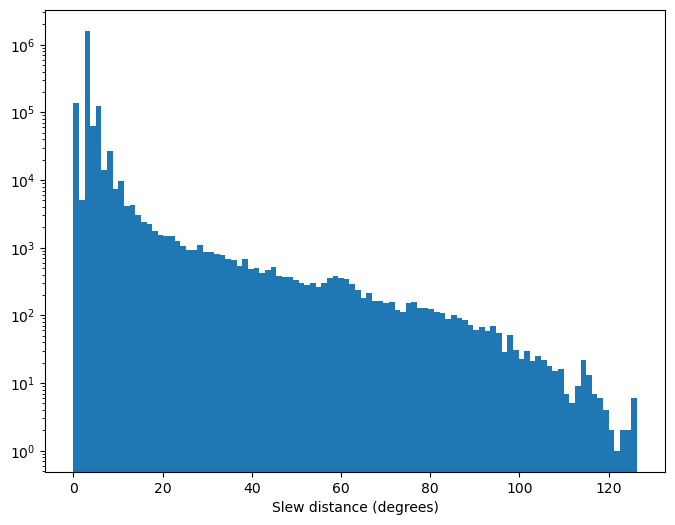

In [12]:
r = 'tma_70_v4.1_10yrs'
plt.figure(figsize=(8, 6))
_ = plt.hist(visits[r].slewDistance, bins=100, log='log') 
_ = plt.xlabel("Slew distance (degrees)")

visits[r].slewDistance.describe()

Plot the actual slew distances and compare with the nominal values from the simple simulation. The simple estimates should be a lower limit (depending on whether a slew moves in altitude or azimuth, and what the camera rotator does, as well as if there is a filter change), and the spread in actual slew times is due to slewing from a variety of points on the sky (rather than just one) and that slews are a combination of azimuth, altitude, camera rotator filter change, settle time, and include dome crawl. 

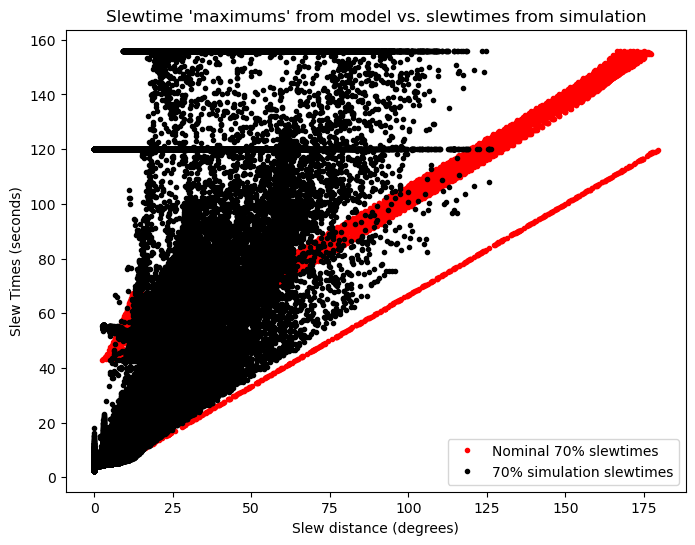

In [13]:
plt.figure(figsize=(8, 6))
r = 'tma_70_v4.1_10yrs'
_ = plt.plot(dists, nominal, 'r.', label = "Nominal 70% slewtimes")
_ = plt.plot(visits[r].slewDistance, visits[r].slewTime, 'k.', label='70% simulation slewtimes')
plt.xlabel("Slew distance (degrees)")
plt.ylabel("Slew Times (seconds)")
plt.legend()
_ = plt.title("Slewtime 'maximums' from model vs. slewtimes from simulation")

Compare the slew times from the various simulations, and then zoom in ..

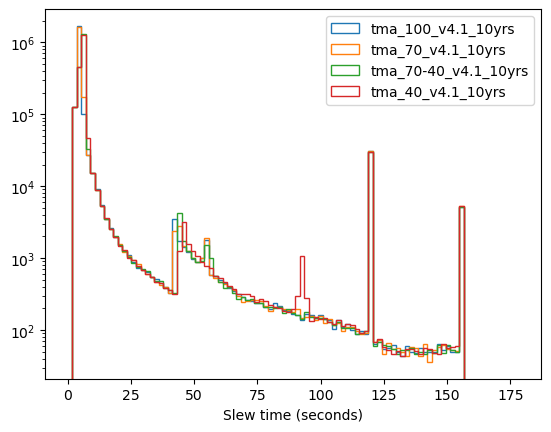

In [14]:
bins = np.arange(0, 180, 1.8)
for r in tmaruns: 
    _ = plt.hist(visits[r]['slewTime'], bins=bins, label=r, log='log', histtype='step')
plt.legend()
_  = plt.xlabel("Slew time (seconds)")

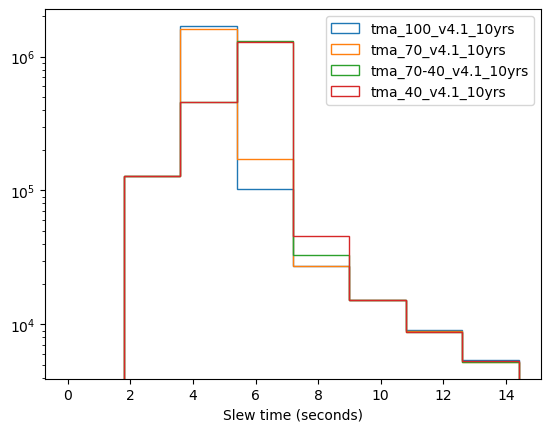

In [15]:
bins = np.arange(0, 15, 1.8)
for r in tmaruns: 
    _ = plt.hist(visits[r]['slewTime'], bins=bins, label=r, log='log', histtype='step')
plt.legend()
_  = plt.xlabel("Slew time (seconds)")

In [16]:
norm = visits['tma_70_v4.1_10yrs']['slewTime'].mean()
for r in tmaruns:
    slew_mean_fractional_change = (visits[r].slewTime.mean() / norm - 1).round(3)
    visit_mean_fractional_change = ((visits[r].slewTime.mean() + 32) / (norm + 32) - 1).round(3)
    print(r, slew_mean_fractional_change, visit_mean_fractional_change)
    display(pd.DataFrame(visits[r].slewTime.describe()).T.round(2))

tma_100_v4.1_10yrs -0.032 -0.006


,count,mean,std,min,25%,50%,75%,max
slewTime,2053032.0,7.63,17.11,2.4,4.6,4.74,4.85,156.0


tma_70_v4.1_10yrs 0.0 0.0


,count,mean,std,min,25%,50%,75%,max
slewTime,2040527.0,7.88,17.12,2.4,4.85,5.02,5.15,156.0


tma_70-40_v4.1_10yrs 0.06 0.012


,count,mean,std,min,25%,50%,75%,max
slewTime,2017510.0,8.36,17.05,2.4,5.36,5.58,5.76,156.0


tma_40_v4.1_10yrs 0.071 0.014


,count,mean,std,min,25%,50%,75%,max
slewTime,2013582.0,8.44,17.2,2.4,5.36,5.59,5.81,156.0


This last cell demonstrates the change in the typical slew time from one simulation to another. The change is 7% in the slewtime for the 40% TMA performance, but stacked onto a 34s visit time, this is only about a 1% change in "time needed per visit". 

In [17]:
import rubin_sim.maf as maf

In [21]:
summaries = maf.get_metric_summaries(summary_source='summary.h5')

In [22]:
metric_subsets = maf.get_metric_subsets()

Comparing the SRD metrics, we see this ~1.4% impact on these high-level metrics. This is also on par with (or less than) the uncertainty expected due to weather. 

metric,fONv MedianNvis fO HealpixSlicer,Median Parallax Uncert (18k) Parallax Uncert @ 22.4 All sky HealpixSlicer,Median Parallax Uncert (18k) Parallax Uncert @ 24.0 All sky HealpixSlicer,Median Parallax Uncert (18k) Parallax Uncert @ 21.3 All sky y band only HealpixSlicer,Median Proper Motion Uncert (18k) Proper Motion Uncert @ 20.5 All sky HealpixSlicer,Median Proper Motion Uncert (18k) Proper Motion Uncert @ 24.0 All sky HealpixSlicer
run,,,,,,
tma_100_v4.1_10yrs,785.0,2.231108,8.837869,8.886404,0.191894,2.202095
tma_70_v4.1_10yrs,779.0,2.232696,8.831976,8.905933,0.192594,2.218339
tma_70-40_v4.1_10yrs,770.0,2.243832,8.891539,8.875812,0.193872,2.235998
tma_40_v4.1_10yrs,769.0,2.260508,8.966838,8.830187,0.194111,2.234165


(<Figure size 1000x600 with 1 Axes>, <Axes: >)

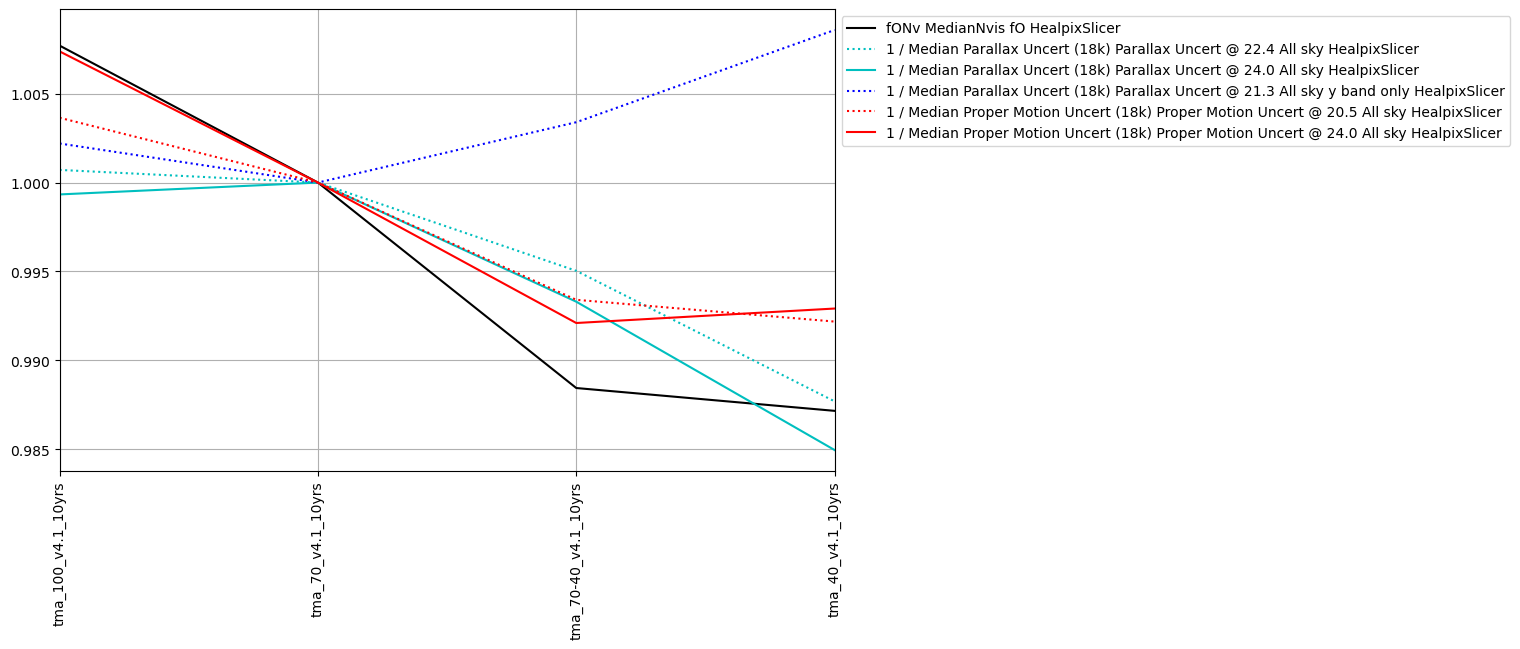

In [33]:
msub = metric_subsets.loc['SRD']
display(summaries.loc[tmaruns, msub['metric']])

maf.plot_run_metric(summaries.loc[tmaruns, msub['metric']], 
                    baseline_run='tma_70_v4.1_10yrs', 
                    metric_subset=msub,
                   horizontal_quantity='run', vertical_quantity='value')